In [75]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [76]:
import numpy as np
import pandas as pd

In [77]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [79]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [80]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [81]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [82]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [83]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [84]:
inspector = inspect(engine)

In [85]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [86]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [87]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [88]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [89]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurements.date, func.max(Measurements.prcp)).\
    group_by(Measurements.date).\
    order_by((Measurements.date).desc()).all()
#results

In [90]:
last_date = session.query(Measurements.date, Measurements.prcp).\
    order_by((Measurements.date).desc()).first()
last_date

('2017-08-23', 0.0)

In [91]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", year_ago)

Query Date:  2016-08-23


In [92]:
# Perform a query to retrieve the data and precipitation scores
day_data = session.query(Measurements.date, func.max(Measurements.prcp)).\
    filter(Measurements.date >= year_ago).\
    group_by(Measurements.date).all()
#day_data

In [113]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(day_data, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
df = df.sort_values(by="Date")

df.set_index('Date', inplace=True)
#df = df.reset_index(drop=True)

#date = df['date_data']
#prcp = df['prcp_data']

df.head()

,Precipitation
Date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18


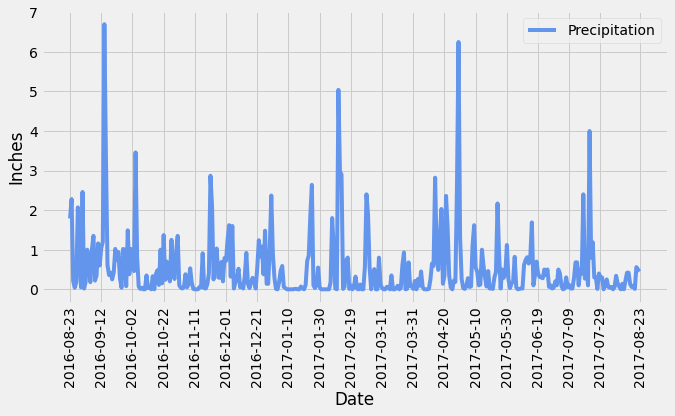

In [114]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90, xticks=(0,20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 365), figsize=(10,5), color='cornflowerblue')
        
plt.xlabel('Date')
plt.ylabel('Inches')

plt.show()

In [95]:
year_data = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date >= year_ago).all()

In [96]:
year_df = pd.DataFrame(year_data, columns=['date', 'prcp'])

In [97]:
year_df.dropna(inplace=True)

In [98]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [99]:
# Design a query to show how many stations are available in this dataset?
station_number = session.query(Stations.station).count()
print(f"There are {station_number} stations available in this dataset")

There are 9 stations available in this dataset


In [100]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurements.station, func.count(Measurements.station)).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [101]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperature=[func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)]

temp_results = session.query(*temperature).\
    filter(Measurements.station == 'USC00519281').all()

print(f"The minimum, maximum, and average recorded temperatures for Station USC00519281 are: {temp_results}")

The minimum, maximum, and average recorded temperatures for Station USC00519281 are: [(54.0, 85.0, 71.66378066378067)]


In [102]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurements.date, Measurements.tobs).\
    filter(Measurements.station == 'USC00519281').\
    filter(Measurements.date >= '2016-08-18').\
    order_by((Measurements.date).desc()).all()

In [103]:
temp_df = pd.DataFrame(temp_data, columns=['date', 'temperature'])
temp_df.set_index('date', inplace=True, )

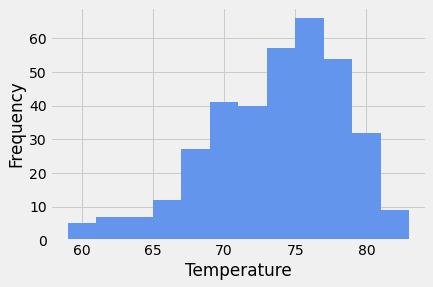

In [104]:
plt.hist(temp_df['temperature'],bins=12,color='cornflowerblue')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

In [117]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [119]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [107]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [108]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [109]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
